<a href="https://colab.research.google.com/github/khaledkoubaa/SeleniumBase/blob/master/face_recognition__pour_sawssen_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# dataset
https://drive.google.com/file/d/12g8MT_yXzIWmmUryj7JdvH5qG4MZfb2r/view?usp=drive_link

### install librairies

In [ ]:
# Install necessary libraries (run this cell first in Colab)
!pip install tensorflow deepface scikit-learn matplotlib seaborn opencv-python Pillow streamlit pyngrok joblib facenet_pytorch mtcnn

# Import statements organized by category
import os
import shutil
import zipfile
import threading
import time
import warnings
from collections import Counter

# Data manipulation
import numpy as np
import pandas as pd

# Image processing
from PIL import Image
import cv2

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Face detection and recognition
from deepface import DeepFace
from mtcnn import MTCNN

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

# Deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout,
    GlobalAveragePooling2D
)
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

# Model persistence
import joblib

# Web app
import streamlit as st
from pyngrok import ngrok

# Suppress warnings
warnings.filterwarnings('ignore')

### connect drive

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define base paths
DRIVE_PATH = '/content/drive/My Drive'
LFW_ZIP_PATH = os.path.join(DRIVE_PATH, 'dataset.zip') # Adjust if your zip file name is different
PROJECT_ROOT = '/content/facial_recognition_project'
os.makedirs(PROJECT_ROOT, exist_ok=True) # Create project root in Colab environment

### Phase 1: Creating Subset from the Main Dataset

In [ ]:
def create_lfw_subset(zip_file_path, min_images_per_person=5, output_dir='lfw_subset'):
    """
    Filters the LFW dataset to create a subset of persons with a minimum number of images.

    Args:
        zip_file_path (str): Path to the LFW dataset zip file.
        min_images_per_person (int): Minimum number of images a person must have to be included.
        output_dir (str): Directory where the filtered subset will be stored.

    Returns:
        str: Path to the created subset directory.
    """
    print(f"Starting LFW subset creation from: {zip_file_path}")

    # Create temporary directory for extraction
    temp_extract_dir = os.path.join(PROJECT_ROOT, 'lfw_extracted_temp')
    os.makedirs(temp_extract_dir, exist_ok=True)

    # Clean up output directory if it already exists
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.makedirs(output_dir, exist_ok=True)

    print(f"Extracting {zip_file_path} to {temp_extract_dir}...")
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(temp_extract_dir)
    print("Extraction complete.")

    # LFW structure is usually lfw-funneled/person_name/image.jpg
    # Find the actual root of the extracted dataset (e.g., 'lfw_funneled')
    extracted_root = None
    for item in os.listdir(temp_extract_dir):
        if os.path.isdir(os.path.join(temp_extract_dir, item)):
            extracted_root = os.path.join(temp_extract_dir, item)
            break

    if not extracted_root:
        raise FileNotFoundError(f"Could not find the main dataset directory inside {temp_extract_dir}. "
                                "Check the structure of your LFW zip file.")
    print(f"Found LFW data root: {extracted_root}")

    # Count images per person
    person_image_counts = Counter()
    for person_name in os.listdir(extracted_root):
        person_path = os.path.join(extracted_root, person_name)
        if os.path.isdir(person_path):
            num_images = len([f for f in os.listdir(person_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            person_image_counts[person_name] = num_images

    # Identify persons meeting the minimum image count
    selected_persons = [person for person, count in person_image_counts.items() if count >= min_images_per_person]
    print(f"Selected {len(selected_persons)} persons with at least {min_images_per_person} images each.")

    # Copy images of selected persons to the output directory
    for person_name in selected_persons:
        source_person_path = os.path.join(extracted_root, person_name)
        dest_person_path = os.path.join(output_dir, person_name)
        os.makedirs(dest_person_path, exist_ok=True) # Create directory for the person in the subset

        for image_file in os.listdir(source_person_path):
            if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                shutil.copy(os.path.join(source_person_path, image_file), dest_person_path)

    print(f"Subset created successfully at: {output_dir}")

    # Clean up temporary extracted directory
    shutil.rmtree(temp_extract_dir)
    print(f"Cleaned up temporary directory: {temp_extract_dir}")
    return output_dir

# --- Run Phase 1 ---
LFW_SUBSET_DIR = os.path.join(PROJECT_ROOT, 'lfw_subset_filtered')
MIN_IMAGES_PER_PERSON = 100 # You can adjust this number
lfw_subset_path = create_lfw_subset(LFW_ZIP_PATH, MIN_IMAGES_PER_PERSON, LFW_SUBSET_DIR)
print(f"LFW Subset Path: {lfw_subset_path}")

# Verify the number of classes and images
total_images = 0
total_persons = 0
if os.path.exists(lfw_subset_path):
    total_persons = len(os.listdir(lfw_subset_path))
    for person_folder in os.listdir(lfw_subset_path):
        person_path = os.path.join(lfw_subset_path, person_folder)
        if os.path.isdir(person_path):
            total_images += len(os.listdir(person_path))
print(f"\nSubset created with {total_persons} persons and {total_images} total images.")

Starting LFW subset creation from: /content/drive/My Drive/dataset.zip
Extracting /content/drive/My Drive/dataset.zip to /content/facial_recognition_project/lfw_extracted_temp...
Extraction complete.
Found LFW data root: /content/facial_recognition_project/lfw_extracted_temp/lfw-deepfunneled
Selected 5 persons with at least 100 images each.
Subset created successfully at: /content/facial_recognition_project/lfw_subset_filtered
Cleaned up temporary directory: /content/facial_recognition_project/lfw_extracted_temp
LFW Subset Path: /content/facial_recognition_project/lfw_subset_filtered

Subset created with 5 persons and 1140 total images.


### Phase 2: model training

Starting Phase 2: Enhanced Model Training and Evaluation
Loading and preprocessing data with enhanced pipeline...
Found 5 persons in the dataset
Processing Colin_Powell (1/5): 236 images
Processing Donald_Rumsfeld (2/5): 121 images
Processing George_W_Bush (3/5): 530 images
Processing Gerhard_Schroeder (4/5): 109 images
Processing Tony_Blair (5/5): 144 images

Dataset loaded: 1140 images, 5 classes
Image shape: (224, 224, 3)

Face detection statistics:
  - Faces detected: 1140
  - Faces not detected (using full image): 0
  - Processing errors: 0


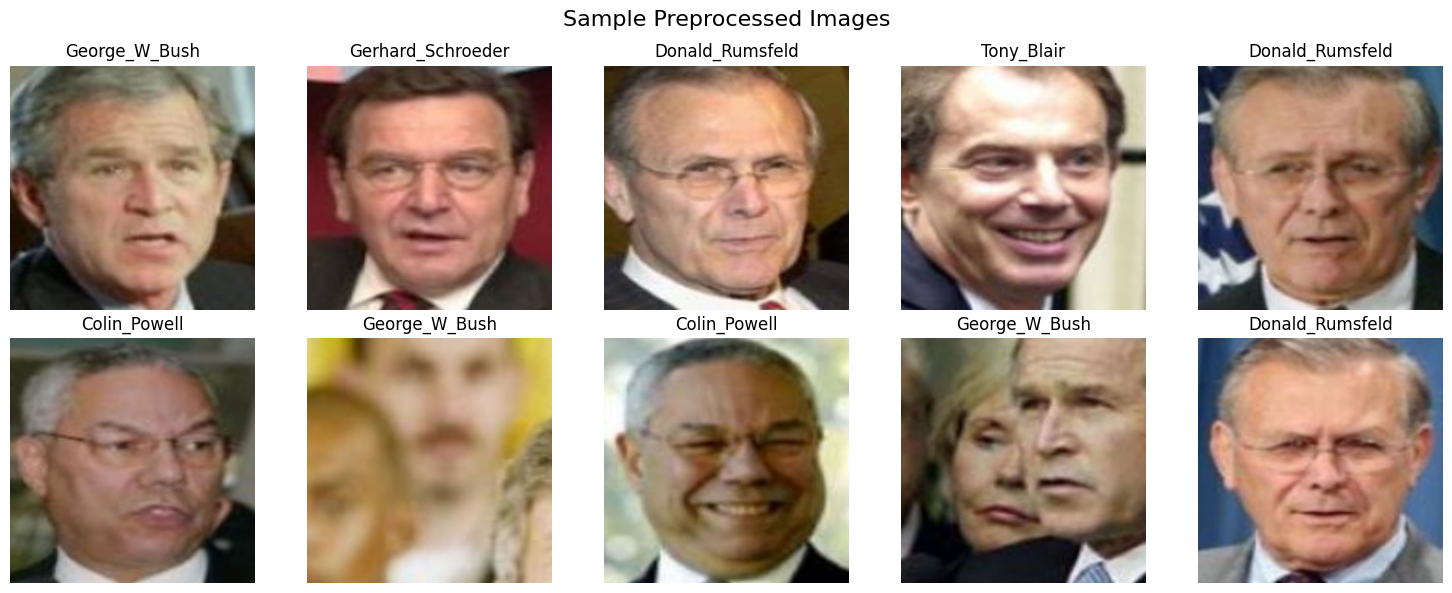


Data split:
Training: 798 images
Validation: 171 images
Testing: 171 images

############################################################
Processing Pure_CNN
############################################################

Training Pure_CNN Model with Enhanced Pipeline

Pure_CNN Model Architecture:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 112, 112, 32)      0         
                      

In [ ]:
# Phase 2: Model Training and Evaluation for Facial Recognition
# Enhanced with advanced preprocessing and face detection

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configuration
IMG_SIZE = (224, 224)  # Standard size for pre-trained models
FACE_SIZE = (160, 160)  # Size for face detection
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.001

# Paths (adjust based on your setup)
PROJECT_ROOT = '/content/facial_recognition_project'
LFW_SUBSET_DIR = os.path.join(PROJECT_ROOT, 'lfw_subset_filtered')
MODELS_DIR = os.path.join(PROJECT_ROOT, 'trained_models')
PREPROCESSED_DIR = os.path.join(PROJECT_ROOT, 'preprocessed_images')
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(PREPROCESSED_DIR, exist_ok=True)

# Initialize MTCNN detector
detector = MTCNN()

def detect_and_extract_face(img_path, target_size=IMG_SIZE, margin=20):
    """
    Detect and extract face from image using MTCNN
    """
    try:
        # Read image
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Detect faces
        results = detector.detect_faces(img_rgb)

        if len(results) > 0:
            # Get the first face (assuming one face per image)
            x, y, width, height = results[0]['box']

            # Add margin to the bounding box
            x = max(0, x - margin)
            y = max(0, y - margin)
            width = width + 2 * margin
            height = height + 2 * margin

            # Ensure we don't exceed image boundaries
            x_end = min(img_rgb.shape[1], x + width)
            y_end = min(img_rgb.shape[0], y + height)

            # Extract face region
            face = img_rgb[y:y_end, x:x_end]

            # Resize to target size
            face_resized = cv2.resize(face, target_size)

            return face_resized, True
        else:
            # If no face detected, return resized original image
            img_resized = cv2.resize(img_rgb, target_size)
            return img_resized, False

    except Exception as e:
        print(f"Error in face detection for {img_path}: {str(e)}")
        return None, False

def preprocess_image(img_array, augment=False):
    """
    Apply preprocessing to image array
    """
    # Normalize pixel values to [0, 1]
    img_normalized = img_array.astype('float32') / 255.0

    if augment:
        # Apply random augmentations
        # Random brightness adjustment
        brightness_factor = np.random.uniform(0.8, 1.2)
        img_normalized = np.clip(img_normalized * brightness_factor, 0, 1)

        # Random contrast adjustment
        contrast_factor = np.random.uniform(0.8, 1.2)
        mean = np.mean(img_normalized)
        img_normalized = np.clip((img_normalized - mean) * contrast_factor + mean, 0, 1)

    return img_normalized

def advanced_augmentation():
    """
    Create advanced data augmentation pipeline
    """
    return ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        zoom_range=0.2,
        shear_range=0.2,
        brightness_range=[0.8, 1.2],
        fill_mode='nearest',
        preprocessing_function=lambda x: x  # Already normalized
    )

def load_and_preprocess_data_enhanced(data_dir, img_size=IMG_SIZE, use_face_detection=True):
    """
    Enhanced loading with face detection and advanced preprocessing
    """
    print("Loading and preprocessing data with enhanced pipeline...")

    images = []
    labels = []
    person_names = []
    face_detection_stats = {'detected': 0, 'not_detected': 0, 'errors': 0}

    # Get all person directories
    person_folders = [f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))]
    person_folders.sort()

    print(f"Found {len(person_folders)} persons in the dataset")

    for person_idx, person_name in enumerate(person_folders):
        person_path = os.path.join(data_dir, person_name)
        person_images = [f for f in os.listdir(person_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        print(f"Processing {person_name} ({person_idx+1}/{len(person_folders)}): {len(person_images)} images")

        for img_file in person_images:
            img_path = os.path.join(person_path, img_file)

            try:
                if use_face_detection:
                    # Use MTCNN for face detection and extraction
                    face_img, face_detected = detect_and_extract_face(img_path, img_size)

                    if face_img is not None:
                        if face_detected:
                            face_detection_stats['detected'] += 1
                        else:
                            face_detection_stats['not_detected'] += 1

                        # Apply preprocessing
                        img_preprocessed = preprocess_image(face_img)
                        images.append(img_preprocessed)
                        labels.append(person_name)
                    else:
                        face_detection_stats['errors'] += 1
                else:
                    # Standard loading without face detection
                    img = Image.open(img_path).convert('RGB')
                    img = img.resize(img_size)
                    img_array = np.array(img)
                    img_preprocessed = preprocess_image(img_array)

                    images.append(img_preprocessed)
                    labels.append(person_name)

            except Exception as e:
                print(f"Error processing {img_path}: {str(e)}")
                face_detection_stats['errors'] += 1
                continue

    # Convert to numpy arrays
    X = np.array(images)
    y = np.array(labels)

    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    print(f"\nDataset loaded: {X.shape[0]} images, {len(np.unique(y_encoded))} classes")
    print(f"Image shape: {X.shape[1:]}")

    if use_face_detection:
        print(f"\nFace detection statistics:")
        print(f"  - Faces detected: {face_detection_stats['detected']}")
        print(f"  - Faces not detected (using full image): {face_detection_stats['not_detected']}")
        print(f"  - Processing errors: {face_detection_stats['errors']}")

    return X, y_encoded, label_encoder, person_folders

def visualize_preprocessing_results(X, y, label_encoder, num_samples=10):
    """
    Visualize preprocessed images
    """
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.ravel()

    # Get random samples
    indices = np.random.choice(len(X), num_samples, replace=False)

    for i, idx in enumerate(indices):
        axes[i].imshow(X[idx])
        axes[i].set_title(f"{label_encoder.inverse_transform([y[idx]])[0]}")
        axes[i].axis('off')

    plt.suptitle("Sample Preprocessed Images", fontsize=16)
    plt.tight_layout()
    plt.savefig(os.path.join(MODELS_DIR, 'preprocessing_samples.png'), dpi=300, bbox_inches='tight')
    plt.show()

def create_pure_cnn_model(input_shape, num_classes):
    """
    Create an enhanced pure CNN model from scratch
    """
    model = Sequential([
        # First block
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Second block
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Third block
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Fourth block
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Dense layers
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    return model

def train_model_enhanced(model, model_name, X_train, y_train, X_val, y_val, num_classes):
    """
    Enhanced training with better callbacks and data augmentation
    """
    print(f"\n{'='*50}")
    print(f"Training {model_name} Model with Enhanced Pipeline")
    print(f"{'='*50}")

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Print model summary
    print(f"\n{model_name} Model Architecture:")
    model.summary()

    # Enhanced data augmentation
    train_datagen = advanced_augmentation()

    # Callbacks
    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        patience=15,
        restore_best_weights=True,
        verbose=1
    )

    model_checkpoint = ModelCheckpoint(
        os.path.join(MODELS_DIR, f'{model_name.lower()}_best.h5'),
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )

    # Train model
    history = model.fit(
        train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
        steps_per_epoch=len(X_train) // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, model_checkpoint, reduce_lr],
        verbose=1
    )

    # Save final model
    model.save(os.path.join(MODELS_DIR, f'{model_name.lower()}_final.h5'))

    return model, history

# ============================================================================
# MAIN EXECUTION
# ============================================================================

def main():
    print("Starting Phase 2: Enhanced Model Training and Evaluation")
    print("="*60)

    # Ask user for preprocessing preference
    use_face_detection = True  # Set to False to disable MTCNN face detection

    # Load and preprocess data with enhanced pipeline
    X, y, label_encoder, class_names = load_and_preprocess_data_enhanced(
        LFW_SUBSET_DIR,
        use_face_detection=use_face_detection
    )
    num_classes = len(class_names)

    # Visualize preprocessing results
    visualize_preprocessing_results(X, y, label_encoder)

    # Save label encoder and class names
    joblib.dump(label_encoder, os.path.join(MODELS_DIR, 'label_encoder.pkl'))
    joblib.dump(class_names, os.path.join(MODELS_DIR, 'class_names.pkl'))

    # Split data
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
    )

    print(f"\nData split:")
    print(f"Training: {X_train.shape[0]} images")
    print(f"Validation: {X_val.shape[0]} images")
    print(f"Testing: {X_test.shape[0]} images")

    # Define models to train
    models_info = [
        ('Pure_CNN', create_pure_cnn_model),
        ('VGG16', create_vgg_model),
        ('ResNet50', create_resnet_model),
        ('MobileNetV2', create_mobilenet_model)
    ]

    # Train and evaluate all models
    results = []
    trained_models = {}

    for model_name, model_creator in models_info:
        print(f"\n{'#'*60}")
        print(f"Processing {model_name}")
        print(f"{'#'*60}")

        # Create model
        model = model_creator(X_train.shape[1:], num_classes)

        # Train model with enhanced pipeline
        trained_model, history = train_model_enhanced(
            model, model_name, X_train, y_train, X_val, y_val, num_classes
        )

        # Plot training history
        plot_training_history(history, model_name)

        # Evaluate model
        result = evaluate_model(trained_model, model_name, X_test, y_test, class_names)
        results.append(result)
        trained_models[model_name] = trained_model

    # Create comparison summary
    print(f"\n{'='*60}")
    print("FINAL RESULTS SUMMARY")
    print(f"{'='*60}")

    results_df = pd.DataFrame([
        {
            'Model': r['model_name'],
            'Accuracy': f"{r['accuracy']:.4f}",
            'Precision': f"{r['precision']:.4f}",
            'Recall': f"{r['recall']:.4f}",
            'F1-Score': f"{r['f1_score']:.4f}"
        }
        for r in results
    ])

    print(results_df.to_string(index=False))

    # Save results summary
    results_df.to_csv(os.path.join(MODELS_DIR, 'model_comparison.csv'), index=False)

    # Plot comparison
    plot_model_comparison(results)

    # Save preprocessing configuration
    preprocessing_config = {
        'img_size': IMG_SIZE,
        'face_detection_used': use_face_detection,
        'normalization': 'min-max (0-1)',
        'augmentation_params': {
            'rotation_range': 20,
            'width_shift_range': 0.2,
            'height_shift_range': 0.2,
            'horizontal_flip': True,
            'zoom_range': 0.2,
            'shear_range': 0.2,
            'brightness_range': [0.8, 1.2]
        }
    }

    joblib.dump(preprocessing_config, os.path.join(MODELS_DIR, 'preprocessing_config.pkl'))

    print(f"\nAll models and results saved in: {MODELS_DIR}")
    print("\nFiles created:")
    for file in sorted(os.listdir(MODELS_DIR)):
        print(f"  - {file}")

    print(f"\n{'='*60}")
    print("Phase 2 Complete! Ready for Phase 3 (Streamlit App)")
    print(f"{'='*60}")

def create_vgg_model(input_shape, num_classes):
    """
    Create VGG16-based model with transfer learning
    """
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Fine-tuning: unfreeze last few layers
    for layer in base_model.layers[:-4]:
        layer.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    return model

def create_resnet_model(input_shape, num_classes):
    """
    Create ResNet50-based model with transfer learning
    """
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    # Fine-tuning: unfreeze last few layers
    for layer in base_model.layers[:-10]:
        layer.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    return model

def create_mobilenet_model(input_shape, num_classes):
    """
    Create MobileNetV2-based model with transfer learning
    """
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

    # Fine-tuning: unfreeze last few layers
    for layer in base_model.layers[:-20]:
        layer.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    return model

def evaluate_model(model, model_name, X_test, y_test, class_names):
    """
    Enhanced model evaluation with additional metrics and visualizations
    """
    print(f"\n{'='*50}")
    print(f"Evaluating {model_name} Model")
    print(f"{'='*50}")

    # Make predictions
    y_pred_proba = model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"\n{model_name} Performance Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    # Per-class metrics
    per_class_precision = precision_score(y_test, y_pred, average=None)
    per_class_recall = recall_score(y_test, y_pred, average=None)
    per_class_f1 = f1_score(y_test, y_pred, average=None)

    # Detailed classification report
    print(f"\nDetailed Classification Report for {model_name}:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix (only if reasonable number of classes)
    if len(class_names) <= 20:
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=class_names, yticklabels=class_names)
        plt.title(f'Confusion Matrix - {model_name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.savefig(os.path.join(MODELS_DIR, f'{model_name.lower()}_confusion_matrix.png'),
                   dpi=300, bbox_inches='tight')
        plt.show()

    # Plot per-class performance
    if len(class_names) <= 30:
        fig, ax = plt.subplots(figsize=(12, 6))
        x = np.arange(len(class_names))
        width = 0.25

        ax.bar(x - width, per_class_precision, width, label='Precision', alpha=0.8)
        ax.bar(x, per_class_recall, width, label='Recall', alpha=0.8)
        ax.bar(x + width, per_class_f1, width, label='F1-Score', alpha=0.8)

        ax.set_xlabel('Classes')
        ax.set_ylabel('Score')
        ax.set_title(f'Per-Class Performance - {model_name}')
        ax.set_xticks(x)
        ax.set_xticklabels(class_names, rotation=45, ha='right')
        ax.legend()
        ax.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig(os.path.join(MODELS_DIR, f'{model_name.lower()}_per_class_performance.png'),
                   dpi=300, bbox_inches='tight')
        plt.show()

    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'predictions': y_pred,
        'probabilities': y_pred_proba,
        'per_class_metrics': {
            'precision': per_class_precision,
            'recall': per_class_recall,
            'f1_score': per_class_f1
        }
    }

def plot_training_history(history, model_name):
    """
    Enhanced plotting of training history
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Plot accuracy
    axes[0, 0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    axes[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    axes[0, 0].set_title(f'{model_name} - Model Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Plot loss
    axes[0, 1].plot(history.history['loss'], label='Training Loss', linewidth=2)
    axes[0, 1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    axes[0, 1].set_title(f'{model_name} - Model Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Plot learning rate if available
    if 'lr' in history.history:
        axes[1, 0].plot(history.history['lr'], label='Learning Rate', linewidth=2, color='green')
        axes[1, 0].set_title(f'{model_name} - Learning Rate')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Learning Rate')
        axes[1, 0].set_yscale('log')
        axes[1, 0].grid(True, alpha=0.3)

    # Plot accuracy vs loss
    axes[1, 1].plot(history.history['val_loss'], history.history['val_accuracy'],
                    'o-', label='Validation', linewidth=2, markersize=4)
    axes[1, 1].plot(history.history['loss'], history.history['accuracy'],
                    's-', label='Training', linewidth=2, markersize=4)
    axes[1, 1].set_title(f'{model_name} - Accuracy vs Loss')
    axes[1, 1].set_xlabel('Loss')
    axes[1, 1].set_ylabel('Accuracy')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(MODELS_DIR, f'{model_name.lower()}_training_history.png'),
               dpi=300, bbox_inches='tight')
    plt.show()

def plot_model_comparison(results):
    """
    Enhanced model comparison visualization
    """
    metrics = ['accuracy', 'precision', 'recall', 'f1_score']

    # Create comparison plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.ravel()

    colors = plt.cm.Set3(np.linspace(0, 1, len(results)))

    for i, metric in enumerate(metrics):
        values = [r[metric] for r in results]
        model_names = [r['model_name'] for r in results]

        bars = axes[i].bar(model_names, values, color=colors)
        axes[i].set_title(f'Model Comparison - {metric.replace("_", " ").title()}')
        axes[i].set_ylabel(metric.replace("_", " ").title())
        axes[i].set_ylim(0, 1.05)

        # Add value labels on bars
        for bar, value in zip(bars, values):
            axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                        f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

        axes[i].tick_params(axis='x', rotation=45)
        axes[i].grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig(os.path.join(MODELS_DIR, 'model_comparison.png'),
               dpi=300, bbox_inches='tight')
    plt.show()

    # Create radar chart for model comparison
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

    angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
    angles += angles[:1]

    for result, color in zip(results, colors):
        values = [result[metric] for metric in metrics]
        values += values[:1]

        ax.plot(angles, values, 'o-', linewidth=2, label=result['model_name'], color=color)
        ax.fill(angles, values, alpha=0.25, color=color)

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels([m.replace('_', ' ').title() for m in metrics])
    ax.set_ylim(0, 1)
    ax.set_title('Model Performance Comparison - Radar Chart', size=16, y=1.08)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    ax.grid(True)

    plt.tight_layout()
    plt.savefig(os.path.join(MODELS_DIR, 'model_comparison_radar.png'),
               dpi=300, bbox_inches='tight')
    plt.show()

if __name__ == "__main__":
    main()

### phase 3: streamlit app en anglais

In [ ]:
# app.py content (Updated to fix DeepFace error and Streamlit deprecation)

# --- Configuration ---
# Ensure this path matches the directory where your models and assets are saved
PROJECT_ROOT = '/content/facial_recognition_project'
MODELS_DIR = os.path.join(PROJECT_ROOT, 'trained_models')
IMG_SIZE = (224, 224) # Ensure this matches the IMG_SIZE used during model training

# Define the filenames of your saved models
MODEL_FILENAMES = {
    'Pure_CNN': 'pure_cnn_final.h5',
    'VGG16': 'vgg16_final.h5',
    'ResNet50': 'resnet50_final.h5',
    'MobileNetV2': 'mobilenetv2_final.h5'
}

# --- Helper Functions ---

@st.cache_resource
def load_all_assets():
    """
    Loads all trained Keras models, the label encoder, and class names.
    Uses st.cache_resource to cache these large objects across app reruns.
    """
    models = {}

    # Load Label Encoder and Class Names
    try:
        label_encoder = joblib.load(os.path.join(MODELS_DIR, 'label_encoder.pkl'))
        class_names = joblib.load(os.path.join(MODELS_DIR, 'class_names.pkl'))
        st.success("Label encoder and class names loaded successfully.")
    except Exception as e:
        st.error(f"Error loading label encoder or class names: {e}. Make sure '{MODELS_DIR}' exists and contains 'label_encoder.pkl' and 'class_names.pkl'.")
        st.stop() # Stop the app if essential assets can't be loaded

    # Load Keras models
    for model_name, filename in MODEL_FILENAMES.items():
        model_path = os.path.join(MODELS_DIR, filename)
        try:
            # compile=False because we only need inference, not re-training
            models[model_name] = load_model(model_path, compile=False)
            st.success(f"{model_name} model loaded successfully.")
        except Exception as e:
            st.error(f"Error loading {model_name} model from {model_path}: {e}. Make sure the .h5 file exists.")
            st.stop()

    return models, label_encoder, class_names

@st.cache_data
def preprocess_image_for_deepface(image_array, target_size=IMG_SIZE):
    """
    Detects a face in the image using DeepFace, aligns it, and resizes it to target_size.
    Returns the preprocessed face image (numpy array ready for model input)
    and the facial area bounding box, or None if no face is found.
    """
    try:
        # DeepFace.extract_faces expects an image path or a numpy array in BGR format.
        # Convert the uploaded RGB image_array to BGR.
        img_bgr = cv2.cvtColor(image_array, cv2.COLOR_RGB2BGR)

        # FIX: DeepFace.extract_faces no longer takes 'target_size' directly.
        # It handles internal resizing for its operations.
        detected_faces = DeepFace.extract_faces(
            img_path=img_bgr, # Pass the BGR numpy array
            detector_backend='opencv', # 'opencv' is generally fast and robust
            enforce_detection=False, # Allows proceeding even if no face is found (we handle this)
            align=True # Align the face to a standard position
        )

        if not detected_faces or len(detected_faces) == 0:
            st.warning("No face detected in the uploaded image. Please try a different image.")
            return None, None

        # Take the first detected face (assuming one primary face per image)
        # DeepFace's 'face' key provides the preprocessed face image.
        face_img = detected_faces[0]['face']

        # FIX: Explicitly resize the face_img to our model's IMG_SIZE,
        # as DeepFace's internal default might vary or not exactly match.
        if face_img.shape[0:2] != target_size:
            face_img = cv2.resize(face_img, target_size)

        # DeepFace often normalizes to [0,1] or [-1,1]. Ensure it's in the [0,1] range for our models.
        # Our training used [0,1] normalization.
        if face_img.min() < 0 or face_img.max() > 1:
            # Scale to [0,1] if it's not already in that range
            face_img = (face_img - face_img.min()) / (face_img.max() - face_img.min())

        # Add a batch dimension: (Height, Width, Channels) -> (1, Height, Width, Channels)
        preprocessed_img = np.expand_dims(face_img, axis=0)

        return preprocessed_img, detected_faces[0]['facial_area'] # Return processed image and its bounding box

    except Exception as e:
        st.error(f"An error occurred during face detection or preprocessing: {e}")
        return None, None

def predict_on_image(processed_img, models, label_encoder, class_names):
    """
    Makes predictions using all loaded models and calculates a consensus prediction.
    """
    results = {}
    all_predictions_indices = [] # Collect all predicted class indices for consensus

    for model_name, model in models.items():
        try:
            # Get prediction probabilities for the preprocessed image
            predictions_proba = model.predict(processed_img, verbose=0)[0]

            # Get the index of the highest probability prediction
            predicted_idx = np.argmax(predictions_proba)
            confidence = predictions_proba[predicted_idx]

            # Decode the predicted class name using the label encoder
            predicted_class_name = label_encoder.inverse_transform([predicted_idx])[0]

            results[model_name] = {
                'predicted_class': predicted_class_name,
                'confidence': confidence,
                'all_probabilities': predictions_proba, # Store full probabilities for detailed breakdown
                'predicted_idx': predicted_idx # Store index for consensus calculation
            }
            all_predictions_indices.append(predicted_idx)

        except Exception as e:
            results[model_name] = {'error': f"Prediction error: {e}"}
            st.warning(f"Failed to get prediction for {model_name}: {e}")

    # --- Consensus Prediction (Simple Majority Vote) ---
    if all_predictions_indices:
        # Count occurrences of each predicted class index
        prediction_counts = {}
        for p_idx in all_predictions_indices:
            prediction_counts[p_idx] = prediction_counts.get(p_idx, 0) + 1

        # Find the maximum count (most common prediction)
        most_common_count = max(prediction_counts.values())

        # Identify all indices that have this maximum count (to handle ties)
        consensus_indices = [idx for idx, count in prediction_counts.items() if count == most_common_count]

        if len(consensus_indices) == 1:
            # If there's a clear majority
            consensus_class_idx = consensus_indices[0]
            consensus_class_name = label_encoder.inverse_transform([consensus_class_idx])[0]

            # Calculate average confidence for the consensus class across all models
            # (regardless of whether they predicted it as top, using its probability)
            avg_consensus_confidence = np.mean([
                res['all_probabilities'][consensus_class_idx]
                for res_name, res in results.items()
                if res_name != 'Consensus' and 'all_probabilities' in res
            ])

            results['Consensus'] = {
                'predicted_class': consensus_class_name,
                'confidence': avg_consensus_confidence,
                'method': 'Majority Vote'
            }
        else:
            # Handle ties: multiple classes have the same maximum number of votes
            consensus_names = [label_encoder.inverse_transform([idx])[0] for idx in consensus_indices]

            # Calculate average confidence for each tied class, then average those
            avg_confidences_tied = []
            for tied_idx in consensus_indices:
                 tied_confidences = [
                    res['all_probabilities'][tied_idx]
                    for res_name, res in results.items()
                    if res_name != 'Consensus' and 'all_probabilities' in res
                 ]
                 if tied_confidences:
                     avg_confidences_tied.append(np.mean(tied_confidences))

            overall_avg_confidence_for_tie = np.mean(avg_confidences_tied) if avg_confidences_tied else 0.0

            results['Consensus'] = {
                'predicted_class': f"Tie among: {', '.join(consensus_names)}",
                'confidence': overall_avg_confidence_for_tie,
                'method': 'Majority Vote (Tie)'
            }
    else:
        results['Consensus'] = {
            'predicted_class': 'N/A',
            'confidence': 'N/A',
            'method': 'No predictions available'
        }

    return results

# --- Streamlit App UI Layout ---

st.set_page_config(
    page_title="Facial Recognition App (LFW)",
    page_icon="👤",
    layout="wide" # Use a wide layout for better display of results
)

st.title("👤 Facial Recognition from LFW Dataset")
st.markdown("Upload an image containing a person's face to identify them using four different deep learning models.")
st.markdown("The app will also provide a consensus prediction based on the models' outputs.")
st.markdown("---")

# Load models, label encoder, and class names (these will be cached)
models, label_encoder, class_names = load_all_assets()

uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    # Convert uploaded file to a numpy array (RGB format)
    image = Image.open(uploaded_file).convert('RGB')
    image_array = np.array(image)

    col1, col2 = st.columns([1, 1]) # Create two columns for layout

    with col1:
        st.subheader("Uploaded Image")
        # FIX: Use use_container_width instead of use_column_width
        st.image(image_array, caption="Uploaded Image", use_container_width=True)

    with col2:
        st.subheader("Processing Image...")
        # Preprocess the image (face detection and alignment)
        processed_face_img_batch, facial_area = preprocess_image_for_deepface(image_array, target_size=IMG_SIZE)

        if processed_face_img_batch is not None:
            # Display the detected and preprocessed face
            # DeepFace output is usually [0,1]. st.image expects [0,1] or [0,255].
            # FIX: Use use_container_width instead of use_column_width
            st.image(processed_face_img_batch[0], caption="Detected and Aligned Face", use_container_width=True, channels="RGB")

            st.subheader("Running Predictions...")
            # Run predictions on the preprocessed face using all models
            prediction_results = predict_on_image(processed_face_img_batch, models, label_encoder, class_names)

            # --- Display Results ---
            st.subheader("Prediction Results")

            # Display Consensus Prediction prominently
            if 'Consensus' in prediction_results:
                consensus = prediction_results['Consensus']
                # Format confidence as percentage if it's a number
                confidence_str = f"{consensus['confidence']:.2%}" if isinstance(consensus['confidence'], (int, float)) else consensus['confidence']
                st.info(f"**Consensus Prediction:** **{consensus['predicted_class']}** (Confidence: {confidence_str}, Method: {consensus['method']})")

            st.markdown("---")
            st.subheader("Individual Model Predictions and Breakdowns")

            # Filter out 'Consensus' key to iterate only through the models
            model_names_for_display = [name for name in MODEL_FILENAMES.keys() if name in prediction_results]

            # Create dynamic columns for individual model results
            model_cols = st.columns(len(model_names_for_display))

            for i, model_name in enumerate(model_names_for_display):
                result = prediction_results[model_name]
                with model_cols[i]:
                    st.markdown(f"### **{model_name}**")
                    if 'error' in result:
                        st.error(result['error'])
                    else:
                        st.write(f"**Predicted Person:** {result['predicted_class']}")
                        st.write(f"**Confidence:** {result['confidence']:.2%}")

                        # Detailed breakdown: Top N probabilities
                        st.markdown("Top 3 Probabilities:")
                        top_n = 3
                        # Get indices and probabilities of the top N predictions
                        top_indices = np.argsort(result['all_probabilities'])[::-1][:top_n]
                        top_probs = result['all_probabilities'][top_indices]
                        top_classes = label_encoder.inverse_transform(top_indices)

                        for j in range(top_n):
                            st.write(f"- **{top_classes[j]}**: {top_probs[j]:.2%}")

        else:
            st.error("Face detection failed. Please ensure the image contains a clear, frontal face.")

st.markdown("---")
st.markdown("This application was developed for facial recognition using a subset of the LFW dataset.")
st.markdown("It demonstrates the use of a custom CNN, VGG16, ResNet50, and MobileNetV2 with transfer learning.")

2025-06-01 13:21:25.391 No runtime found, using MemoryCacheStorageManager
2025-06-01 13:21:25.395 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-01 13:21:25.403 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-01 13:21:25.404 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-01 13:21:25.405 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-01 13:21:25.405 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-01 13:21:25.406 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-01 13:21:25.407 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-01 13:21:25.408 Thread 'MainThread':

DeltaGenerator()

In [ ]:
ngrok.set_auth_token("2xuMUAdWjdBU4dFxUEx1G3NeokZ_5M5vNMqb6pJdEAq3aqQTz")

In [ ]:
# Phase 3: Streamlit App for Facial Recognition (Updated)
# This code should be run after Phase 1 and Phase 2 in Google Colab

# Configuration
PROJECT_ROOT = '/content/facial_recognition_project'
MODELS_DIR = os.path.join(PROJECT_ROOT, 'trained_models')
IMG_SIZE = (224, 224)

# Create the Streamlit app file
streamlit_app_code = '''
import streamlit as st
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import load_model
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Configuration
PROJECT_ROOT = '/content/facial_recognition_project'
MODELS_DIR = os.path.join(PROJECT_ROOT, 'trained_models')
IMG_SIZE = (224, 224)

# Set page config
st.set_page_config(
    page_title="Facial Recognition App",
    page_icon="👤",
    layout="wide"
)

@st.cache_resource
def load_models_and_encoders():
    """Load all trained models and encoders"""
    models = {}

    # Load models
    model_files = {
        'Pure CNN': 'pure_cnn_final.h5',
        'VGG16': 'vgg16_final.h5',
        'ResNet50': 'resnet50_final.h5',
        'MobileNetV2': 'mobilenetv2_final.h5'
    }

    for model_name, file_name in model_files.items():
        model_path = os.path.join(MODELS_DIR, file_name)
        if os.path.exists(model_path):
            models[model_name] = load_model(model_path)
            print(f"Loaded {model_name}")
        else:
            st.error(f"Model file not found: {model_path}")

    # Load label encoder and class names
    label_encoder = joblib.load(os.path.join(MODELS_DIR, 'label_encoder.pkl'))
    class_names = joblib.load(os.path.join(MODELS_DIR, 'class_names.pkl'))

    return models, label_encoder, class_names

def preprocess_image(image):
    """Preprocess image for model prediction"""
    # Convert to RGB if necessary
    if image.mode != 'RGB':
        image = image.convert('RGB')

    # Resize image
    image = image.resize(IMG_SIZE)

    # Convert to array and normalize
    img_array = np.array(image) / 255.0

    # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)

    return img_array

def make_predictions(image, models):
    """Make predictions using all models"""
    predictions = {}

    for model_name, model in models.items():
        # Get predictions
        pred_proba = model.predict(image, verbose=0)
        pred_class = np.argmax(pred_proba[0])
        confidence = pred_proba[0][pred_class]

        # Get top 3 predictions
        top_3_indices = np.argsort(pred_proba[0])[-3:][::-1]
        top_3_probs = pred_proba[0][top_3_indices]

        predictions[model_name] = {
            'predicted_class': pred_class,
            'confidence': confidence,
            'all_probabilities': pred_proba[0],
            'top_3_indices': top_3_indices,
            'top_3_probs': top_3_probs
        }

    return predictions

def plot_prediction_bars(predictions, class_names, model_name):
    """Create bar plot for top predictions"""
    pred_data = predictions[model_name]
    top_indices = pred_data['top_3_indices']
    top_probs = pred_data['top_3_probs']
    top_names = [class_names[i] for i in top_indices]

    fig, ax = plt.subplots(figsize=(8, 4))
    bars = ax.bar(top_names, top_probs)

    # Color the highest probability bar differently
    bars[0].set_color('green')

    ax.set_ylabel('Confidence')
    ax.set_title(f'{model_name} - Top 3 Predictions')
    ax.set_ylim(0, 1)

    # Add value labels on bars
    for bar, prob in zip(bars, top_probs):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{prob:.3f}', ha='center', va='bottom')

    plt.tight_layout()
    return fig

def get_consensus_predictions_sorted(predictions, class_names):
    """Get all model predictions sorted by confidence"""
    # Collect all predictions with their confidence scores
    all_model_predictions = []

    for model_name, pred_data in predictions.items():
        all_model_predictions.append({
            'model': model_name,
            'predicted_class': pred_data['predicted_class'],
            'predicted_name': class_names[pred_data['predicted_class']],
            'confidence': pred_data['confidence']
        })

    # Sort by confidence (highest first)
    sorted_predictions = sorted(all_model_predictions, key=lambda x: x['confidence'], reverse=True)

    # Get weighted consensus (considering confidence scores)
    class_confidence_sum = {}
    class_count = {}

    for pred in all_model_predictions:
        class_idx = pred['predicted_class']
        if class_idx not in class_confidence_sum:
            class_confidence_sum[class_idx] = 0
            class_count[class_idx] = 0
        class_confidence_sum[class_idx] += pred['confidence']
        class_count[class_idx] += 1

    # Calculate average confidence for each predicted class
    class_avg_confidence = {}
    for class_idx in class_confidence_sum:
        class_avg_confidence[class_idx] = class_confidence_sum[class_idx] / class_count[class_idx]

    # Find the class with highest average confidence
    best_class = max(class_avg_confidence, key=class_avg_confidence.get)

    return {
        'sorted_predictions': sorted_predictions,
        'best_prediction': {
            'class': best_class,
            'name': class_names[best_class],
            'avg_confidence': class_avg_confidence[best_class],
            'num_models': class_count[best_class]
        },
        'class_stats': {
            'confidence_sum': class_confidence_sum,
            'count': class_count,
            'avg_confidence': class_avg_confidence
        }
    }

# Main app
def main():
    st.title("🎯 Facial Recognition System")
    st.markdown("Upload an image to identify the person using 4 different deep learning models")

    # Load models
    with st.spinner("Loading models..."):
        models, label_encoder, class_names = load_models_and_encoders()

    if not models:
        st.error("No models could be loaded. Please check if Phase 2 was completed successfully.")
        return

    st.success(f"✅ Loaded {len(models)} models successfully!")

    # Sidebar with information
    with st.sidebar:
        st.header("ℹ️ Information")
        st.write(f"**Number of people:** {len(class_names)}")
        st.write(f"**Models available:** {len(models)}")
        st.write("**Models:**")
        for model_name in models.keys():
            st.write(f"- {model_name}")

        st.divider()
        st.write("**People in database:**")
        for i, name in enumerate(class_names):
            st.write(f"{i+1}. {name}")

    # File uploader
    uploaded_file = st.file_uploader(
        "Choose an image...",
        type=['jpg', 'jpeg', 'png'],
        help="Upload a clear face image for best results"
    )

    if uploaded_file is not None:
        # Display uploaded image
        col1, col2 = st.columns([1, 2])

        with col1:
            st.subheader("📸 Uploaded Image")
            image = Image.open(uploaded_file)
            st.image(image, use_column_width=True)

        with col2:
            # Preprocess image
            with st.spinner("Processing image..."):
                processed_image = preprocess_image(image)

            # Make predictions
            with st.spinner("Making predictions..."):
                predictions = make_predictions(processed_image, models)

            # Get consensus predictions sorted by confidence
            consensus_data = get_consensus_predictions_sorted(predictions, class_names)
            sorted_preds = consensus_data['sorted_predictions']

            # Display top prediction
            st.subheader("🎯 Model Predictions (Sorted by Confidence)")

            # Show the highest confidence prediction
            top_pred = sorted_preds[0]
            col_top1, col_top2, col_top3 = st.columns(3)
            with col_top1:
                st.metric("Best Prediction", top_pred['predicted_name'])
            with col_top2:
                st.metric("Confidence", f"{top_pred['confidence']*100:.1f}%")
            with col_top3:
                st.metric("Model", top_pred['model'])

            # Show all predictions sorted by confidence
            st.write("**All Model Predictions (Sorted by Confidence):**")
            for i, pred in enumerate(sorted_preds):
                confidence_color = "🟢" if pred['confidence'] > 0.8 else "🟡" if pred['confidence'] > 0.5 else "🔴"
                st.write(f"{i+1}. {confidence_color} **{pred['model']}**: {pred['predicted_name']} ({pred['confidence']*100:.1f}%)")

        st.divider()

        # Individual model predictions
        st.subheader("📊 Individual Model Predictions")

        # Create tabs for each model
        tabs = st.tabs(list(models.keys()))

        for i, (model_name, tab) in enumerate(zip(models.keys(), tabs)):
            with tab:
                pred_data = predictions[model_name]
                predicted_person = class_names[pred_data['predicted_class']]
                confidence = pred_data['confidence']

                # Display metrics
                col1, col2 = st.columns([1, 2])

                with col1:
                    st.metric("Predicted Person", predicted_person)
                    st.metric("Confidence", f"{confidence*100:.2f}%")

                    # Show confidence level indicator
                    if confidence > 0.8:
                        st.success("High confidence")
                    elif confidence > 0.5:
                        st.warning("Medium confidence")
                    else:
                        st.error("Low confidence")

                with col2:
                    # Plot top predictions
                    fig = plot_prediction_bars(predictions, class_names, model_name)
                    st.pyplot(fig)
                    plt.close()

        st.divider()

        # Detailed predictions table
        with st.expander("📋 View Detailed Analysis"):
            # Create comparison dataframe sorted by confidence
            comparison_data = []
            for pred in sorted_preds:
                model_name = pred['model']
                pred_data = predictions[model_name]
                comparison_data.append({
                    'Model': model_name,
                    'Predicted Person': pred['predicted_name'],
                    'Confidence': f"{pred['confidence']*100:.2f}%",
                    '2nd Choice': class_names[pred_data['top_3_indices'][1]],
                    '2nd Confidence': f"{pred_data['top_3_probs'][1]*100:.2f}%"
                })

            comparison_df = pd.DataFrame(comparison_data)
            st.dataframe(comparison_df, use_container_width=True)

            # Show consensus analysis
            st.subheader("Consensus Analysis")
            best_pred = consensus_data['best_prediction']
            st.write(f"**Weighted Best Prediction:** {best_pred['name']}")
            st.write(f"**Average Confidence:** {best_pred['avg_confidence']*100:.1f}%")
            st.write(f"**Number of models predicting this:** {best_pred['num_models']}/4")

            # Show all probabilities heatmap
            st.subheader("Probability Heatmap")

            # Create heatmap data
            heatmap_data = []
            model_order = [pred['model'] for pred in sorted_preds]  # Sort models by their confidence
            for model_name in model_order:
                heatmap_data.append(predictions[model_name]['all_probabilities'])

            heatmap_df = pd.DataFrame(
                heatmap_data,
                index=model_order,
                columns=class_names
            )

            fig, ax = plt.subplots(figsize=(12, 4))
            sns.heatmap(heatmap_df, annot=True, fmt='.3f', cmap='YlOrRd',
                       cbar_kws={'label': 'Probability'}, ax=ax)
            ax.set_xlabel('Person')
            ax.set_ylabel('Model (sorted by confidence)')
            plt.tight_layout()
            st.pyplot(fig)
            plt.close()

if __name__ == "__main__":
    main()
'''

# Write the Streamlit app to a file
app_path = os.path.join(PROJECT_ROOT, 'facial_recognition_app.py')
with open(app_path, 'w') as f:
    f.write(streamlit_app_code)

print(f"Streamlit app created at: {app_path}")

# Function to run Streamlit in a separate thread
def run_streamlit():
    os.system(f'streamlit run {app_path} --server.port 8501')

# Start Streamlit in a separate thread
thread = threading.Thread(target=run_streamlit)
thread.daemon = True
thread.start()

# Give Streamlit time to start
time.sleep(5)

# Create public URL using ngrok
public_url = ngrok.connect(addr='8501', proto='http')

print(f"\n{'='*60}")
print("🎉 Streamlit app is running!")
print(f"{'='*60}")
print(f"\n📱 Access your app at: {public_url}")
print("\nNote: This URL will be active as long as this cell is running.")
print("To stop the app, interrupt the kernel.")
print(f"\n{'='*60}")

# Keep the cell running
try:
    while True:
        time.sleep(1)
except KeyboardInterrupt:
    print("\nShutting down...")
    ngrok.kill()

Streamlit app created at: /content/facial_recognition_project/facial_recognition_app.py

🎉 Streamlit app is running!

📱 Access your app at: NgrokTunnel: "https://a53b-34-125-22-109.ngrok-free.app" -> "http://localhost:8501"

Note: This URL will be active as long as this cell is running.
To stop the app, interrupt the kernel.


Shutting down...


### phase 3: streamlit app * en français

In [ ]:
ngrok.set_auth_token("2xuMUAdWjdBU4dFxUEx1G3NeokZ_5M5vNMqb6pJdEAq3aqQTz")

# Phase 3: Streamlit App for Facial Recognition (Updated)
# This code should be run after Phase 1 and Phase 2 in Google Colab
# Phase 3 : Application Streamlit pour la Reconnaissance Faciale (Mise à jour)
# Ce code doit être exécuté après les Phases 1 et 2 dans Google Colab

# Configuration
PROJECT_ROOT = '/content/facial_recognition_project'
MODELS_DIR = os.path.join(PROJECT_ROOT, 'trained_models')
IMG_SIZE = (224, 224)

# Create the Streamlit app file
# Créer le fichier de l'application Streamlit
streamlit_app_code = '''
import streamlit as st
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import load_model
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Configuration
PROJECT_ROOT = '/content/facial_recognition_project'
MODELS_DIR = os.path.join(PROJECT_ROOT, 'trained_models')
IMG_SIZE = (224, 224)

# Set page config / Configurer la page
st.set_page_config(
    page_title="Application de Reconnaissance Faciale",
    page_icon="👤",
    layout="wide"
)

@st.cache_resource
def load_models_and_encoders():
    """Load all trained models and encoders"""
    # """Charger tous les modèles entraînés et les encodeurs"""
    models = {}

    # Load models / Charger les modèles
    # Note: Les noms de modèles comme VGG16 sont conservés car ce sont des noms techniques.
    # 'Pure CNN' est traduit car c'est un nom descriptif.
    model_files = {
        'CNN Pur': 'pure_cnn_final.h5', # Traduit
        'VGG16': 'vgg16_final.h5',
        'ResNet50': 'resnet50_final.h5',
        'MobileNetV2': 'mobilenetv2_final.h5'
    }

    for model_name, file_name in model_files.items():
        model_path = os.path.join(MODELS_DIR, file_name)
        if os.path.exists(model_path):
            models[model_name] = load_model(model_path)
            print(f"Chargé {model_name}") # Message de console
        else:
            st.error(f"Fichier modèle non trouvé : {model_path}")

    # Load label encoder and class names / Charger l'encodeur d'étiquettes et les noms de classes
    label_encoder = joblib.load(os.path.join(MODELS_DIR, 'label_encoder.pkl'))
    class_names = joblib.load(os.path.join(MODELS_DIR, 'class_names.pkl'))

    return models, label_encoder, class_names

def preprocess_image(image):
    """Preprocess image for model prediction"""
    # """Prétraiter l'image pour la prédiction du modèle"""
    # Convert to RGB if necessary / Convertir en RVB si nécessaire
    if image.mode != 'RGB':
        image = image.convert('RGB')

    # Resize image / Redimensionner l'image
    image = image.resize(IMG_SIZE)

    # Convert to array and normalize / Convertir en tableau et normaliser
    img_array = np.array(image) / 255.0

    # Add batch dimension / Ajouter une dimension de lot
    img_array = np.expand_dims(img_array, axis=0)

    return img_array

def make_predictions(image, models):
    """Make predictions using all models"""
    # """Faire des prédictions en utilisant tous les modèles"""
    predictions = {}

    for model_name, model in models.items():
        # Get predictions / Obtenir les prédictions
        pred_proba = model.predict(image, verbose=0)
        pred_class = np.argmax(pred_proba[0])
        confidence = pred_proba[0][pred_class]

        # Get top 3 predictions / Obtenir les 3 meilleures prédictions
        top_3_indices = np.argsort(pred_proba[0])[-3:][::-1]
        top_3_probs = pred_proba[0][top_3_indices]

        predictions[model_name] = {
            'predicted_class': pred_class,
            'confidence': confidence,
            'all_probabilities': pred_proba[0],
            'top_3_indices': top_3_indices,
            'top_3_probs': top_3_probs
        }

    return predictions

def plot_prediction_bars(predictions, class_names, model_name):
    """Create bar plot for top predictions"""
    # """Créer un diagramme à barres pour les meilleures prédictions"""
    pred_data = predictions[model_name]
    top_indices = pred_data['top_3_indices']
    top_probs = pred_data['top_3_probs']
    top_names = [class_names[i] for i in top_indices]

    fig, ax = plt.subplots(figsize=(8, 4))
    bars = ax.bar(top_names, top_probs)

    # Color the highest probability bar differently / Colorer différemment la barre de probabilité la plus élevée
    bars[0].set_color('green')

    ax.set_ylabel('Confiance')
    ax.set_title(f'{model_name} - Top 3 Prédictions')
    ax.set_ylim(0, 1)

    # Add value labels on bars / Ajouter des étiquettes de valeur sur les barres
    for bar, prob in zip(bars, top_probs):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{prob:.3f}', ha='center', va='bottom')

    plt.tight_layout()
    return fig

def get_consensus_predictions_sorted(predictions, class_names):
    """Get all model predictions sorted by confidence"""
    # """Obtenir toutes les prédictions des modèles triées par confiance"""
    # Collect all predictions with their confidence scores
    # Collecter toutes les prédictions avec leurs scores de confiance
    all_model_predictions = []

    for model_name, pred_data in predictions.items():
        all_model_predictions.append({
            'model': model_name, # clé
            'predicted_class': pred_data['predicted_class'], # clé
            'predicted_name': class_names[pred_data['predicted_class']], # clé
            'confidence': pred_data['confidence'] # clé
        })

    # Sort by confidence (highest first)
    # Trier par confiance (la plus élevée en premier)
    sorted_predictions = sorted(all_model_predictions, key=lambda x: x['confidence'], reverse=True)

    # Get weighted consensus (considering confidence scores)
    # Obtenir un consensus pondéré (en considérant les scores de confiance)
    class_confidence_sum = {}
    class_count = {}

    for pred in all_model_predictions:
        class_idx = pred['predicted_class']
        if class_idx not in class_confidence_sum:
            class_confidence_sum[class_idx] = 0
            class_count[class_idx] = 0
        class_confidence_sum[class_idx] += pred['confidence']
        class_count[class_idx] += 1

    # Calculate average confidence for each predicted class
    # Calculer la confiance moyenne pour chaque classe prédite
    class_avg_confidence = {}
    for class_idx in class_confidence_sum:
        class_avg_confidence[class_idx] = class_confidence_sum[class_idx] / class_count[class_idx]

    # Find the class with highest average confidence
    # Trouver la classe avec la confiance moyenne la plus élevée
    best_class = max(class_avg_confidence, key=class_avg_confidence.get)

    return {
        'sorted_predictions': sorted_predictions, # clé
        'best_prediction': { # clé
            'class': best_class, # clé
            'name': class_names[best_class], # clé
            'avg_confidence': class_avg_confidence[best_class], # clé
            'num_models': class_count[best_class] # clé
        },
        'class_stats': { # clé
            'confidence_sum': class_confidence_sum, # clé
            'count': class_count, # clé
            'avg_confidence': class_avg_confidence # clé
        }
    }

# Main app / Application principale
def main():
    st.title("🎯 Système de Reconnaissance Faciale")
    st.markdown("Chargez une image pour identifier la personne à l'aide de 4 modèles d'apprentissage profond différents")

    # Load models / Charger les modèles
    with st.spinner("Chargement des modèles..."):
        models, label_encoder, class_names = load_models_and_encoders()

    if not models:
        st.error("Aucun modèle n'a pu être chargé. Veuillez vérifier si la Phase 2 s'est terminée avec succès.")
        return

    st.success(f"✅ {len(models)} modèles chargés avec succès !")

    # Sidebar with information / Barre latérale avec informations
    with st.sidebar:
        st.header("ℹ️ Informations")
        st.write(f"**Nombre de personnes :** {len(class_names)}")
        st.write(f"**Modèles disponibles :** {len(models)}")
        st.write("**Modèles :**")
        for model_name in models.keys():
            st.write(f"- {model_name}")

        st.divider()
        st.write("**Personnes dans la base de données :**")
        for i, name in enumerate(class_names):
            st.write(f"{i+1}. {name}")

    # File uploader / Chargeur de fichiers
    uploaded_file = st.file_uploader(
        "Choisissez une image...",
        type=['jpg', 'jpeg', 'png'],
        help="Chargez une image de visage claire pour de meilleurs résultats"
    )

    if uploaded_file is not None:
        # Display uploaded image / Afficher l'image téléchargée
        col1, col2 = st.columns([1, 2])

        with col1:
            st.subheader("📸 Image Téléchargée")
            image = Image.open(uploaded_file)
            st.image(image, use_column_width=True)

        with col2:
            # Preprocess image / Prétraiter l'image
            with st.spinner("Traitement de l'image..."):
                processed_image = preprocess_image(image)

            # Make predictions / Faire des prédictions
            with st.spinner("Calcul des prédictions..."):
                predictions = make_predictions(processed_image, models)

            # Get consensus predictions sorted by confidence
            # Obtenir les prédictions par consensus triées par confiance
            consensus_data = get_consensus_predictions_sorted(predictions, class_names)
            sorted_preds = consensus_data['sorted_predictions']

            # Display top prediction / Afficher la meilleure prédiction
            st.subheader("🎯 Prédictions des Modèles (Triées par Confiance)")

            # Show the highest confidence prediction
            # Afficher la prédiction avec la plus haute confiance
            top_pred = sorted_preds[0]
            col_top1, col_top2, col_top3 = st.columns(3)
            with col_top1:
                st.metric("Meilleure Prédiction", top_pred['predicted_name'])
            with col_top2:
                st.metric("Confiance", f"{top_pred['confidence']*100:.1f}%")
            with col_top3:
                st.metric("Modèle", top_pred['model'])

            # Show all predictions sorted by confidence
            # Afficher toutes les prédictions triées par confiance
            st.write("**Toutes les Prédictions des Modèles (Triées par Confiance) :**")
            for i, pred in enumerate(sorted_preds):
                confidence_color = "🟢" if pred['confidence'] > 0.8 else "🟡" if pred['confidence'] > 0.5 else "🔴"
                st.write(f"{i+1}. {confidence_color} **{pred['model']}** : {pred['predicted_name']} ({pred['confidence']*100:.1f}%)")

        st.divider()

        # Individual model predictions / Prédictions individuelles des modèles
        st.subheader("📊 Prédictions Individuelles des Modèles")

        # Create tabs for each model / Créer des onglets pour chaque modèle
        tabs = st.tabs(list(models.keys())) # 'onglets' serait aussi possible pour la variable

        for i, (model_name, tab) in enumerate(zip(models.keys(), tabs)):
            with tab:
                pred_data = predictions[model_name]
                predicted_person = class_names[pred_data['predicted_class']]
                confidence = pred_data['confidence']

                # Display metrics / Afficher les métriques
                col1, col2 = st.columns([1, 2])

                with col1:
                    st.metric("Personne Prédite", predicted_person)
                    st.metric("Confiance", f"{confidence*100:.2f}%")

                    # Show confidence level indicator / Afficher l'indicateur de niveau de confiance
                    if confidence > 0.8:
                        st.success("Confiance élevée")
                    elif confidence > 0.5:
                        st.warning("Confiance moyenne")
                    else:
                        st.error("Confiance faible")

                with col2:
                    # Plot top predictions / Tracer les meilleures prédictions
                    fig = plot_prediction_bars(predictions, class_names, model_name)
                    st.pyplot(fig)
                    plt.close() # Fermer la figure pour libérer la mémoire

        st.divider()

        # Detailed predictions table / Tableau détaillé des prédictions
        with st.expander("📋 Voir l'Analyse Détaillée"):
            # Create comparison dataframe sorted by confidence
            # Créer un dataframe de comparaison trié par confiance
            comparison_data = []
            for pred in sorted_preds:
                model_name = pred['model']
                pred_data = predictions[model_name]
                comparison_data.append({
                    'Modèle': model_name,
                    'Personne Prédite': pred['predicted_name'],
                    'Confiance': f"{pred['confidence']*100:.2f}%",
                    '2ème Choix': class_names[pred_data['top_3_indices'][1]],
                    'Confiance 2ème Choix': f"{pred_data['top_3_probs'][1]*100:.2f}%" # Traduction de '2nd Confidence'
                })

            comparison_df = pd.DataFrame(comparison_data)
            st.dataframe(comparison_df, use_container_width=True)

            # Show consensus analysis / Afficher l'analyse du consensus
            st.subheader("Analyse du Consensus")
            best_pred = consensus_data['best_prediction']
            st.write(f"**Meilleure Prédiction Pondérée :** {best_pred['name']}")
            st.write(f"**Confiance Moyenne :** {best_pred['avg_confidence']*100:.1f}%")
            st.write(f"**Nombre de modèles prédisant ceci :** {best_pred['num_models']}/4")

            # Show all probabilities heatmap / Afficher la carte de chaleur de toutes les probabilités
            st.subheader("Carte de Chaleur des Probabilités")

            # Create heatmap data / Créer les données de la carte de chaleur
            heatmap_data = []
            model_order = [pred['model'] for pred in sorted_preds]  # Sort models by their confidence / Trier les modèles par leur confiance
            for model_name in model_order:
                heatmap_data.append(predictions[model_name]['all_probabilities'])

            heatmap_df = pd.DataFrame(
                heatmap_data,
                index=model_order,
                columns=class_names
            )

            fig, ax = plt.subplots(figsize=(12, 4))
            sns.heatmap(heatmap_df, annot=True, fmt='.3f', cmap='YlOrRd',
                       cbar_kws={'label': 'Probabilité'}, ax=ax)
            ax.set_xlabel('Personne')
            ax.set_ylabel('Modèle (trié par confiance)')
            plt.tight_layout()
            st.pyplot(fig)
            plt.close() # Fermer la figure

if __name__ == "__main__":
    main()
'''

# Write the Streamlit app to a file / Écrire l'application Streamlit dans un fichier
app_path = os.path.join(PROJECT_ROOT, 'facial_recognition_app_fr.py') # Nom de fichier modifié pour la version FR
with open(app_path, 'w', encoding='utf-8') as f: # Ajout de encoding='utf-8'
    f.write(streamlit_app_code)

print(f"Application Streamlit créée à : {app_path}")

# Function to run Streamlit in a separate thread / Fonction pour exécuter Streamlit dans un thread séparé
def run_streamlit():
    # Modifier pour utiliser le nouveau nom de fichier
    os.system(f'streamlit run {app_path} --server.port 8501')

# Start Streamlit in a separate thread / Démarrer Streamlit dans un thread séparé
thread = threading.Thread(target=run_streamlit)
thread.daemon = True
thread.start()

# Give Streamlit time to start / Donner du temps à Streamlit pour démarrer
time.sleep(5)

# Create public URL using ngrok / Créer une URL publique en utilisant ngrok
public_url = ngrok.connect(addr='8501', proto='http')

print(f"\n{'='*60}")
print("🎉 L'application Streamlit est en cours d'exécution !")
print(f"{'='*60}")
print(f"\n📱 Accédez à votre application à : {public_url}")
print("\nNote : Cette URL sera active tant que cette cellule sera en cours d'exécution.")
print("Pour arrêter l'application, interrompez le noyau.")
print(f"\n{'='*60}")

# Keep the cell running / Maintenir la cellule en exécution
try:
    while True:
        time.sleep(1)
except KeyboardInterrupt:
    print("\nArrêt en cours...")
    ngrok.kill()